In [15]:
import polars as pl
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import json

In [55]:
df_answers_1 = pl.read_csv("../answers/answers_1.csv")
df_answers_2 = pl.read_csv("../answers/answers_2.csv")


df_indiviudal_1 = pl.read_csv("../individuals/individuals_1.csv")
df_indiviudal_2 = pl.read_csv("../individuals/individuals_2.csv")


df_properties = pl.read_csv("../statementproperties/statementproperties_1.csv")

df_statements = pl.read_csv("../statements/statements_1.csv")

# 1. Concatenate the two DataFrames vertically
df_answers = pl.concat([df_answers_1, df_answers_2], how="vertical")

# 2. Concatenate the two DataFrames vertically
df_indiviudal = pl.concat([df_indiviudal_1, df_indiviudal_2], how="vertical")


df_answers.group_by("sessionId")



In [17]:
df_answers.group_by("sessionId").agg(pl.count("sessionId").alias("count")).filter(
    pl.col("count") >= 15
)

sessionId,count
str,u32
"""HNeIPIu_QNzY7QxwnVJeL37odefwxf…",15
"""HKESysQ2qMgblDPPCTjVgfakvb2Pr0…",15
"""GPn1vhp5RQZgnWqvKJEWnpowhzGsR4…",15
"""o4YGJRd7xKO8O-W1OQ5UppBnT3w76a…",15
"""0BtI7eDjg9M1Cbsh1tIbva8gQ6PMTc…",15
…,…
"""ePoWnCiJk14fEX2_jCXAg44DA5KlW4…",15
"""nssnkw4KY9Cu3IlhO1mlLe7ph6lBTn…",15
"""SiZnVRI8kDAIF1533tfvc5OBeWWklM…",15


In [18]:
df_answers = df_answers.with_columns(
    [pl.col("I_agree").cast(pl.Float64), pl.col("others_agree").cast(pl.Float64)]
)

df_answers.head(4)

id,I_agree,I_agree_reason,others_agree,others_agree_reason,perceived_commonsense,clarity,origLanguage,sessionId,createdAt,updatedAt,statement_number,statementId,clientVersion
i64,f64,str,f64,str,i64,str,str,str,str,str,i64,i64,str
1,1.0,"""It's obvious""",1.0,"""I think most people have good …",1,"""Clear: it is clearly written a…","""en""","""uZBSJf5x8X7I1vvwiX4K7YfrB7hY_t…","""2023-06-14 17:11:11""","""2023-06-14 17:11:11""",6,6,null
2,1.0,"""It's something I learned""",1.0,"""I think most people have good …",1,"""Clear: it is clearly written a…","""en""","""siFSQa8F_h3woRq5maLEsmoDQmA-ws…","""2023-06-14 17:11:17""","""2023-06-14 17:11:17""",6,6,null
3,1.0,"""It's something I learned""",1.0,"""I think most people have good …",1,"""Clear: it is clearly written a…","""en""","""7A2Xy3lMfn_Pe12DeucuE-1swxAv34…","""2023-06-14 17:11:23""","""2023-06-14 17:11:23""",6,6,null
4,1.0,"""It's obvious""",1.0,"""I think most people lack good …",0,"""Clear: it is clearly written a…","""en""","""n4yeiqY8p1DDUmxhKphavobA-w5LCn…","""2023-06-14 17:11:27""","""2023-06-14 17:11:27""",149,149,null


In [ ]:
df_median = df_answers.group_by("statementId").agg(
    pl.col("I_agree").median().alias("median_I_agree")
)

df_joined = df_answers.join(df_median, on="statementId", how="left")

df_joined = df_joined.with_columns(
    [
        (pl.col("I_agree") == pl.col("median_I_agree"))
        .cast(pl.Float64)
        .alias("is_consensus"),
        pl.when(pl.col("median_I_agree") == 0.5)
        .then(1.0)
        .otherwise(
            (pl.col("others_agree") == pl.col("median_I_agree")).cast(pl.Float64)
        )
        .alias("is_aware"),
    ]
)

df_joined.head(4)

id,I_agree,I_agree_reason,others_agree,others_agree_reason,perceived_commonsense,clarity,origLanguage,sessionId,createdAt,updatedAt,statement_number,statementId,clientVersion,median_I_agree,is_consensus,is_aware
i64,f64,str,f64,str,i64,str,str,str,str,str,i64,i64,str,f64,f64,f64
1,1.0,"""It's obvious""",1.0,"""I think most people have good …",1,"""Clear: it is clearly written a…","""en""","""uZBSJf5x8X7I1vvwiX4K7YfrB7hY_t…","""2023-06-14 17:11:11""","""2023-06-14 17:11:11""",6,6,null,1.0,1.0,1.0
2,1.0,"""It's something I learned""",1.0,"""I think most people have good …",1,"""Clear: it is clearly written a…","""en""","""siFSQa8F_h3woRq5maLEsmoDQmA-ws…","""2023-06-14 17:11:17""","""2023-06-14 17:11:17""",6,6,null,1.0,1.0,1.0
3,1.0,"""It's something I learned""",1.0,"""I think most people have good …",1,"""Clear: it is clearly written a…","""en""","""7A2Xy3lMfn_Pe12DeucuE-1swxAv34…","""2023-06-14 17:11:23""","""2023-06-14 17:11:23""",6,6,null,1.0,1.0,1.0
4,1.0,"""It's obvious""",1.0,"""I think most people lack good …",0,"""Clear: it is clearly written a…","""en""","""n4yeiqY8p1DDUmxhKphavobA-w5LCn…","""2023-06-14 17:11:27""","""2023-06-14 17:11:27""",149,149,null,1.0,1.0,1.0


In [24]:
df_joined.shape

(790771, 17)

In [20]:
df_session = (
    df_joined.group_by("sessionId")
    .agg(
        [
            pl.col("is_consensus").mean().alias("consensus"),
            pl.col("is_aware").mean().alias("awareness"),
            pl.len().alias("response_count"),
        ]
    )
    .filter(pl.col("response_count") > 10)
    .with_columns(
        (pl.col("awareness") * pl.col("consensus")).sqrt().alias("commonsensicality")
    )
)

df_session = df_session.with_columns(
    ((pl.col("awareness") * pl.col("consensus")).sqrt()).alias("commonsensicality")
)

df_session

sessionId,consensus,awareness,response_count,commonsensicality
str,f64,f64,u32,f64
"""iZDj_cqwnPBKRKSTfRauPkNXijy0jU…",0.8,0.933333,15,0.864099
"""oR6TOtsUlkQ8GIik64aMhVkqqbFn7Y…",1.0,0.857143,14,0.92582
"""Bzh7VDYIE4_o6ZeZ6BeR1pPVbQJ0Cl…",0.714286,0.5,14,0.597614
"""wO_1n8JlY5tBnRD3vtr_WWbQLgczkU…",0.933333,0.866667,15,0.899383
"""bCV9aLMphKzdVUnKJ5KJj-50_X40YJ…",0.866667,0.6,15,0.72111
…,…,…,…,…
"""cuAeB696HHN5QRu_qGOFOJmfNp_HZz…",0.857143,1.0,14,0.92582
"""wwSpFQhvAl2s8J-w2BOOJSF7m--KmT…",1.0,0.866667,15,0.930949
"""zi6aF7LEoH8xqsFnqduYh_j0dZjBDd…",1.0,0.733333,15,0.856349


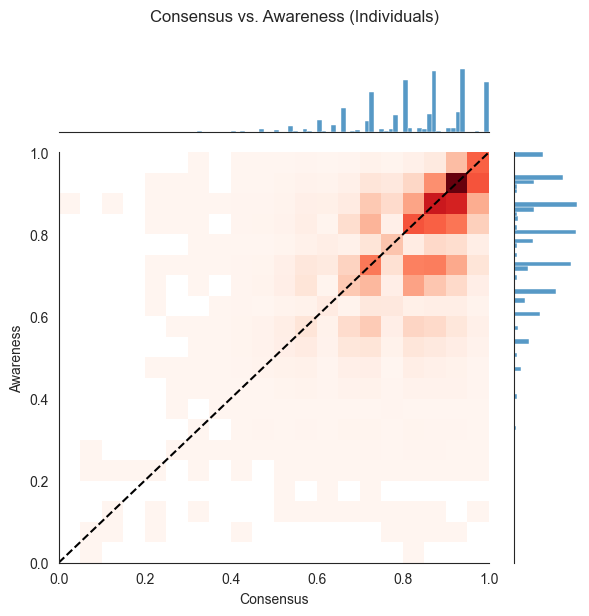

In [21]:
# json.loads(df_indiviudal[100].select("experimentInfo").to_numpy()[0][0])

df_pandas = df_session.to_pandas()


sns.set_style("white")
g = sns.jointplot(
    data=df_pandas, x="consensus", y="awareness", kind="hist", bins=20, cmap="Reds"
)


g.ax_joint.plot([0, 1], [0, 1], ls="--", color="black")


g.ax_joint.set_xlim(0, 1)
g.ax_joint.set_ylim(0, 1)
g.set_axis_labels("Consensus", "Awareness")
plt.suptitle("Consensus vs. Awareness (Individuals)", y=1.02)

plt.tight_layout()
plt.show()

In [22]:
df_properties

id,name,available,createdAt,updatedAt,statementId
i64,str,i64,str,str,i64
1,"""behavior""",0,"""2023-04-08 12:23:26""","""2023-04-08 12:23:26""",1
2,"""everyday""",1,"""2023-04-08 12:23:26""","""2023-04-08 12:23:26""",1
3,"""figure_of_speech""",0,"""2023-04-08 12:23:26""","""2023-04-08 12:23:26""",1
4,"""judgment""",0,"""2023-04-08 12:23:26""","""2023-04-08 12:23:26""",1
5,"""opinion""",0,"""2023-04-08 12:23:26""","""2023-04-08 12:23:26""",1
…,…,…,…,…,…
60656,"""everyday""",1,"""2025-02-18 14:49:40""","""2025-02-18 14:49:40""",8859
60657,"""figure_of_speech""",0,"""2025-02-18 14:49:40""","""2025-02-18 14:49:40""",8859
60658,"""judgment""",1,"""2025-02-18 14:49:40""","""2025-02-18 14:49:40""",8859


In [27]:
properties_wide = df_properties.pivot(
    index="statementId",
    columns="name",
    values="available",
)

properties_wide

/var/folders/5j/9pnb21r14qjbflhqq7gq72lr0000gn/T/ipykernel_35322/1597815251.py:1: DeprecationWarning: The argument `columns` for `DataFrame.pivot` is deprecated. It has been renamed to `on`.
  properties_wide = df_properties.pivot(


statementId,behavior,everyday,figure_of_speech,judgment,opinion,reasoning
i64,i64,i64,i64,i64,i64,i64
1,0,1,0,0,0,1
2,0,0,0,0,0,0
3,1,1,0,1,0,1
4,0,1,0,0,0,0
5,0,1,0,1,1,0
…,…,…,…,…,…,…
8855,1,1,0,1,1,1
8856,1,1,0,1,1,1
8857,1,1,0,1,1,1


In [72]:
joined_answer_df = df_joined.join(
    properties_wide, 
    on="statementId",   
    how="inner"         
)

joined_answer_df.head(4)

id,I_agree,I_agree_reason,others_agree,others_agree_reason,perceived_commonsense,clarity,origLanguage,sessionId,createdAt,updatedAt,statement_number,statementId,clientVersion,median_I_agree,is_consensus,is_aware,behavior,everyday,figure_of_speech,judgment,opinion,reasoning
i64,f64,str,f64,str,i64,str,str,str,str,str,i64,i64,str,f64,f64,f64,i64,i64,i64,i64,i64,i64
1,1.0,"""It's obvious""",1.0,"""I think most people have good …",1,"""Clear: it is clearly written a…","""en""","""uZBSJf5x8X7I1vvwiX4K7YfrB7hY_t…","""2023-06-14 17:11:11""","""2023-06-14 17:11:11""",6,6,null,1.0,1.0,1.0,0,1,0,0,1,1
2,1.0,"""It's something I learned""",1.0,"""I think most people have good …",1,"""Clear: it is clearly written a…","""en""","""siFSQa8F_h3woRq5maLEsmoDQmA-ws…","""2023-06-14 17:11:17""","""2023-06-14 17:11:17""",6,6,null,1.0,1.0,1.0,0,1,0,0,1,1
3,1.0,"""It's something I learned""",1.0,"""I think most people have good …",1,"""Clear: it is clearly written a…","""en""","""7A2Xy3lMfn_Pe12DeucuE-1swxAv34…","""2023-06-14 17:11:23""","""2023-06-14 17:11:23""",6,6,null,1.0,1.0,1.0,0,1,0,0,1,1
4,1.0,"""It's obvious""",1.0,"""I think most people lack good …",0,"""Clear: it is clearly written a…","""en""","""n4yeiqY8p1DDUmxhKphavobA-w5LCn…","""2023-06-14 17:11:27""","""2023-06-14 17:11:27""",149,149,null,1.0,1.0,1.0,0,0,1,1,0,1


In [32]:
medians_means = (
    joined_answer_df
    .group_by("statementId")
    .agg([
        pl.col("I_agree").median().alias("median_i_agree"),
        pl.col("I_agree").mean().alias("mean_i_agree"),
    ])
)

medians_means.head(3)

statementId,median_i_agree,mean_i_agree
i64,f64,f64
3561,0.0,0.333333
9051,1.0,0.811005
1444,1.0,0.644737


In [34]:
answers_with_medians = joined_answer_df.join(medians_means, on="statementId")
answers_with_medians.head(3)

id,I_agree,I_agree_reason,others_agree,others_agree_reason,perceived_commonsense,clarity,origLanguage,sessionId,createdAt,updatedAt,statement_number,statementId,clientVersion,median_I_agree,is_consensus,is_aware,behavior,everyday,figure_of_speech,judgment,opinion,reasoning,median_i_agree,mean_i_agree
i64,f64,str,f64,str,i64,str,str,str,str,str,i64,i64,str,f64,f64,f64,i64,i64,i64,i64,i64,i64,f64,f64
1,1.0,"""It's obvious""",1.0,"""I think most people have good …",1,"""Clear: it is clearly written a…","""en""","""uZBSJf5x8X7I1vvwiX4K7YfrB7hY_t…","""2023-06-14 17:11:11""","""2023-06-14 17:11:11""",6,6,null,1.0,1.0,1.0,0,1,0,0,1,1,1.0,0.965517
2,1.0,"""It's something I learned""",1.0,"""I think most people have good …",1,"""Clear: it is clearly written a…","""en""","""siFSQa8F_h3woRq5maLEsmoDQmA-ws…","""2023-06-14 17:11:17""","""2023-06-14 17:11:17""",6,6,null,1.0,1.0,1.0,0,1,0,0,1,1,1.0,0.965517
3,1.0,"""It's something I learned""",1.0,"""I think most people have good …",1,"""Clear: it is clearly written a…","""en""","""7A2Xy3lMfn_Pe12DeucuE-1swxAv34…","""2023-06-14 17:11:23""","""2023-06-14 17:11:23""",6,6,null,1.0,1.0,1.0,0,1,0,0,1,1,1.0,0.965517


In [36]:
answers_with_awareness = answers_with_medians.with_columns(
    pl.when(pl.col("median_i_agree") == 0.5)
    .then(pl.lit(1.0))
    .otherwise((pl.col("others_agree") == pl.col("median_i_agree")).cast(pl.Float64()))
    .alias("awareness_row")
)

In [44]:
answers_with_awareness.head(3)

id,I_agree,I_agree_reason,others_agree,others_agree_reason,perceived_commonsense,clarity,origLanguage,sessionId,createdAt,updatedAt,statement_number,statementId,clientVersion,median_I_agree,is_consensus,is_aware,behavior,everyday,figure_of_speech,judgment,opinion,reasoning,median_i_agree,mean_i_agree,awareness_row
i64,f64,str,f64,str,i64,str,str,str,str,str,i64,i64,str,f64,f64,f64,i64,i64,i64,i64,i64,i64,f64,f64,f64
1,1.0,"""It's obvious""",1.0,"""I think most people have good …",1,"""Clear: it is clearly written a…","""en""","""uZBSJf5x8X7I1vvwiX4K7YfrB7hY_t…","""2023-06-14 17:11:11""","""2023-06-14 17:11:11""",6,6,null,1.0,1.0,1.0,0,1,0,0,1,1,1.0,0.965517,1.0
2,1.0,"""It's something I learned""",1.0,"""I think most people have good …",1,"""Clear: it is clearly written a…","""en""","""siFSQa8F_h3woRq5maLEsmoDQmA-ws…","""2023-06-14 17:11:17""","""2023-06-14 17:11:17""",6,6,null,1.0,1.0,1.0,0,1,0,0,1,1,1.0,0.965517,1.0
3,1.0,"""It's something I learned""",1.0,"""I think most people have good …",1,"""Clear: it is clearly written a…","""en""","""7A2Xy3lMfn_Pe12DeucuE-1swxAv34…","""2023-06-14 17:11:23""","""2023-06-14 17:11:23""",6,6,null,1.0,1.0,1.0,0,1,0,0,1,1,1.0,0.965517,1.0


In [40]:
statement_commonsense = (
    answers_with_awareness.group_by("statementId")
    .agg(
        [
            pl.col("awareness_row").mean().alias("statement_awareness"),
            pl.col("mean_i_agree").mean().alias("mean_of_mean_i_agree"),
        ]
    )
    .with_columns(
        [(2 * (pl.col("mean_of_mean_i_agree") - 0.5).abs()).alias("statement_consensus")]
    )
    .with_columns(
        [
            (pl.col("statement_awareness") * pl.col("statement_consensus"))
            .sqrt()
            .alias("actual_commonsensicality")
        ]
    )
    .select(["statementId", "statement_awareness", "statement_consensus", "actual_commonsensicality"])
)

In [71]:
statement_commonsensicality_with_properties = statement_commonsense.join(properties_wide, on="statementId", how="left")

# statement_commonsensicality_with_properties

In [70]:
long_df = statement_commonsensicality_with_properties.melt(
    id_vars=["statementId", "actual_commonsensicality"],
    value_vars=[
        "behavior",
        "everyday",
        "figure_of_speech",
        "judgment",
        "opinion",
        "reasoning",
    ],
    variable_name="property_name",
    value_name="has_property",
)

# long_df

/var/folders/5j/9pnb21r14qjbflhqq7gq72lr0000gn/T/ipykernel_35322/1008483862.py:1: DeprecationWarning: `DataFrame.melt` is deprecated. Use `unpivot` instead, with `index` instead of `id_vars` and `on` instead of `value_vars`
  long_df = statement_commonsensicality_with_properties.melt(


In [52]:
import numpy as np

boot_res = []

n_boot = 500
prop_list = [
    "behavior",
    "everyday",
    "figure_of_speech",
    "judgment",
    "opinion",
    "reasoning",
]

for prop in prop_list:

    true_vals = long_df.filter(
        (pl.col("property_name") == prop) & (pl.col("has_property") == 1)
    )["actual_commonsensicality"].to_numpy()
    false_vals = long_df.filter(
        (pl.col("property_name") == prop) & (pl.col("has_property") == 0)
    )["actual_commonsensicality"].to_numpy()

    nT = len(true_vals)
    nF = len(false_vals)
    for _ in range(n_boot):
        sample_T = np.random.choice(true_vals, size=nT, replace=True)
        sample_F = np.random.choice(false_vals, size=nF, replace=True)
        mean_diff = sample_T.mean() - sample_F.mean()
        boot_res.append((prop, mean_diff))


boot_df = pl.DataFrame(boot_res, schema=["property_name", "difference_mean"])

/var/folders/5j/9pnb21r14qjbflhqq7gq72lr0000gn/T/ipykernel_35322/3102902135.py:33: DataOrientationWarning: Row orientation inferred during DataFrame construction. Explicitly specify the orientation by passing `orient="row"` to silence this warning.
  boot_df = pl.DataFrame(boot_res, schema=["property_name", "difference_mean"])


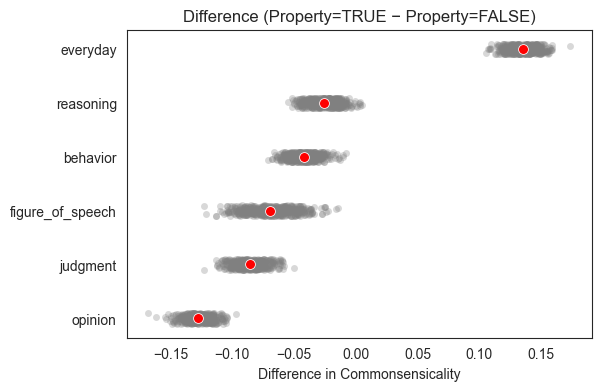

In [69]:
mean_diffs = (
    boot_df.group_by("property_name")
    .agg(pl.col("difference_mean").mean().alias("mean_diff"))
    .sort("mean_diff", descending=True)
)

mean_df_pd = mean_diffs.to_pandas()

cat_order = mean_df_pd["property_name"].tolist()


plt.figure(figsize=(6, 4))


sns.stripplot(
    data=boot_df.to_pandas(),
    x="difference_mean",
    y="property_name",
    alpha=0.3,
    color="gray",
    order=cat_order,
)

sns.scatterplot(
    data=mean_df_pd,
    x="mean_diff",
    y="property_name",
    color="red",
    s=50,
    zorder=10,
    hue_order=cat_order,
)


plt.xlabel("Difference in Commonsensicality")
plt.ylabel("")
plt.title("Difference (Property=TRUE − Property=FALSE)")
plt.show()

In [58]:
category_plot_df = statement_commonsensicality_with_properties.join(
    df_statements, left_on="statementId", right_on="id", how="left"
)

In [63]:
category_means = (
    category_plot_df.group_by("statementCategory")
    .agg([pl.col("actual_commonsensicality").mean().alias("mean_commonsensicality")])
    .sort("mean_commonsensicality",descending=True)
)


cat_means_pd = category_means.to_pandas()
cat_order = cat_means_pd["statementCategory"].tolist()

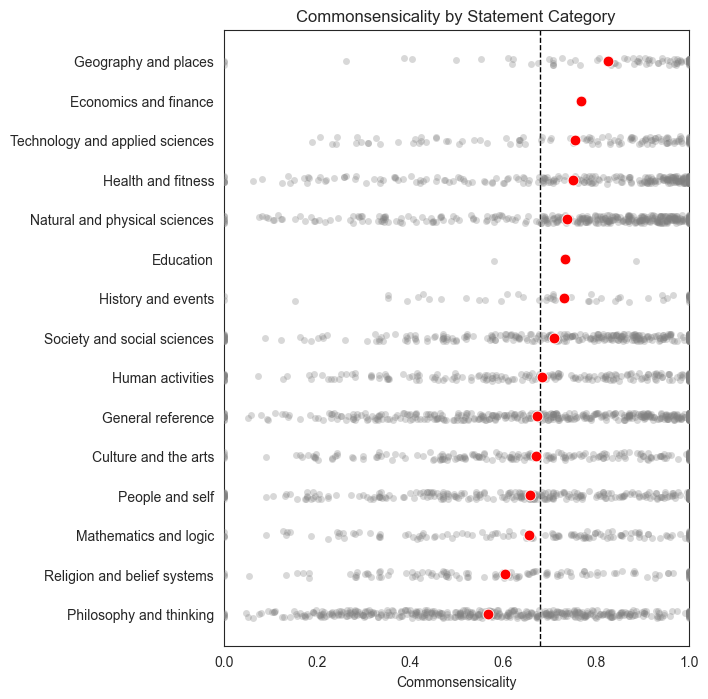

In [65]:
plot_df_pd = category_plot_df.to_pandas()

plt.figure(figsize=(6, 8))


ax = sns.stripplot(
    data=plot_df_pd,
    x="actual_commonsensicality",
    y="statementCategory",
    order=cat_order,
    alpha=0.3,
    color="gray",
    jitter=True,
)


mean_points_pd = cat_means_pd.rename(columns={"mean_commonsensicality": "x"})
sns.scatterplot(
    data=mean_points_pd,
    x="x",
    y="statementCategory",
    hue_order=cat_order,
    color="red",
    s=60,
    zorder=10,
    ax=ax,
)


overall_mean = plot_df_pd["actual_commonsensicality"].mean()

plt.axvline(x=overall_mean, color="black", linestyle="--", linewidth=1)

plt.xlim(0, 1)
plt.xlabel("Commonsensicality")
plt.ylabel("")
plt.title("Commonsensicality by Statement Category")
plt.show()

## Design point average commonsensicality

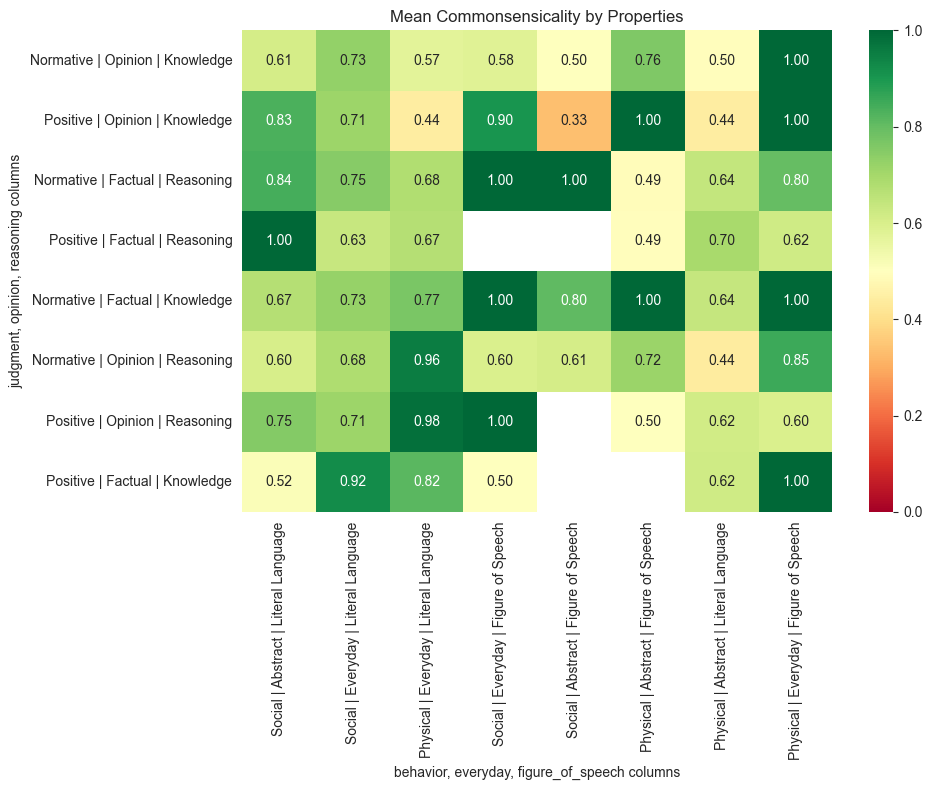

In [120]:
replace_dict = {
    "behavior": {"Physical": 0, "Social": 1},
    "everyday": {"Abstract": 0, "Everyday": 1},
    "figure_of_speech": {"Literal Language": 0, "Figure of Speech": 1},
    "judgment": {"Positive": 0, "Normative": 1},
    "opinion": {"Factual": 0, "Opinion": 1},
    "reasoning": {"Knowledge": 0, "Reasoning": 1},
}
inv_replace_dict = {
    col: {v: k for k, v in mapping.items()} for col, mapping in replace_dict.items()
}


df_replaced = statement_commonsensicality_with_properties

for col in inv_replace_dict.keys():
    df_replaced = df_replaced.with_columns(
        pl.col(col)
        .map_elements(
            lambda x: inv_replace_dict[col].get(x, f"Unmapped_{x}"),
            return_dtype=pl.String,
        )
        .alias(col)
    )

df_with_labels = df_replaced.with_columns(
    [
        pl.format(
            "{} | {} | {}",
            pl.col("behavior"),
            pl.col("everyday"),
            pl.col("figure_of_speech"),
        ).alias("x_label"),
        pl.format(
            "{} | {} | {}", pl.col("judgment"), pl.col("opinion"), pl.col("reasoning")
        ).alias("y_label"),
    ]
)

df_heat = (
    df_with_labels.group_by(["x_label", "y_label"])
    .agg([pl.col("actual_commonsensicality").mean().alias("avg_commonsensicality")])
    .pivot(
        index="y_label",
        on="x_label",
        values="avg_commonsensicality",
    )
)

df_heat_pd = df_heat.to_pandas()


df_heat_pd = df_heat_pd.set_index("y_label")

plt.figure(figsize=(10, 8))

sns.heatmap(
    df_heat_pd,
    cmap="RdYlGn",
    vmin=0,
    vmax=1,
    annot=True,
    fmt=".2f",
)

plt.title("Mean Commonsensicality by Properties")
plt.xlabel("behavior, everyday, figure_of_speech columns")
plt.ylabel("judgment, opinion, reasoning columns")
plt.tight_layout()
plt.show()